# IMPORTING LIBRARIES

In [11]:
!pip install --upgrade scikit-learn scipy
!pip install beautifulsoup4
!pip install tensorflow
!pip install keras
!pip install pandas
!pip install matplotlib
!pip install seaborn 
!pip install tensorflow --upgrade
!pip install keras --upgrade

  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/b2/e4/30b53d839608d2212b97972a8516ba0c7e776ee1102eaa82624807b944cf/keras-3.0.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/999.1 kB ? eta -:--:--
   - -------------------------------------- 30.7/999.1 kB 1.4 MB/s eta 0:00:01
   -------------- ------------------------- 368.6/999.1 kB 5.8 MB/s eta 0:00:01
   ------------------------------- -------- 788.5/999.1 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 999.1/999.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.1 which is incompatible.


In [1]:
import re
import string
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow


from keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from bs4 import BeautifulSoup
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer



import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from  nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

DATASET_ENCODING = "ISO-8859-1"

POSITIVE = "Positive"
NEGATIVE = "Negative"
NEUTRAL = "Neutral"
SENT_THRESH = (0.4, 0.7)



In [2]:
nltk.download('stop_words')
nltk.download('vader_lexicon')
stemmer = SnowballStemmer("english")
stop_words = stopwords.words("english")
FORMATTED = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
from nltk.tokenize import TweetTokenizer

[nltk_data] Error loading stop_words: Package 'stop_words' not found
[nltk_data]     in index
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tobby\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading my dataset

In [3]:
import pandas as pd
# Assuming your dataset is in a CSV file named 'your_dataset.csv'
file_path = 'your_dataset.csv'

# Read the dataset with encoding 'utf-8'
df = pd.read_csv('Movie review.Train.csv', encoding='utf-8')

# Display the first few rows of the dataset
df =pd.read_csv('Movie review.Train.csv', encoding =DATASET_ENCODING)

In [4]:
df.head()

,ï»¿text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
df.rename(columns={'ï»¿text': 'text'}, inplace=True)
df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


# General Analysis

In [6]:
df.shape

(40000, 2)

In [7]:
df.tail()

,text,label
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1
39999,"Why would this film be so good, but only gross...",1


In [8]:
df.dtypes

text     object
label     int64
dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [10]:
df.describe()

,label
count,40000.000000
mean,0.499525
std,0.500006
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [11]:
df.isna().sum()

text     0
label    0
dtype: int64

In [12]:
df["label"].value_counts()

label
0    20019
1    19981
Name: count, dtype: int64

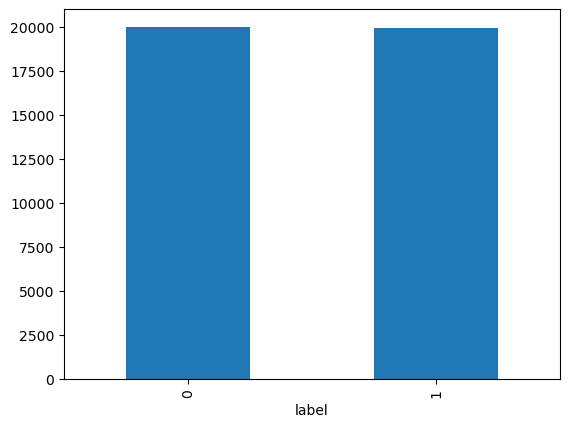

In [13]:
df["label"].value_counts().plot.bar()
plt.show()

# Cleaning my Dataset

In [14]:
# Removing Punctuation
def cleaning (df):
    df = df.lower()
    df =  re.sub(r'@\S+', '',df)  # remove twitter handles
    df =  re.sub(r'http\S+', '',df) # remove urls
    df =  re.sub(r'pic.\S+', '',df)
    df =  re.sub(r"[^a-zA-ZáéíóúÁÉÍÓÚ']", ' ',df) # only keeps characters
    df =  re.sub(r'\s+[a-zA-ZáéíóúÁÉÍÓÚ]\s+', ' ', df+' ')  # keep words with length>1 only
    df = "".join([i for i in df if i not in string.punctuation])
    words = word_tokenize(df)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    df = " ".join([i for i in words if i not in stopwords])
    df= re.sub("\s[\s]+", " ",df).strip()
    df= re.sub("\s[\s]+", " ",df).strip() # remove repeated/leading/trailing spaces
    return df

In [15]:
df["text"]=df["text"].apply(cleaning)

In [16]:
from nltk.tokenize import word_tokenize

# Preprocessing function
def preprocess_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download the Punkt tokenizer and WordNet resources
nltk.download('punkt')
nltk.download('wordnet')

# Other imports and code...

def preprocess_text(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Remove punctuation and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]
    # Remove stop words
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Additional preprocessing steps...
    return " ".join(tokens)

df['text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tobby\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tobby\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
df.head()

,text,label
0,grew watching loving thunderbird mate school w...,0
1,put movie dvd player sat coke chip expectation...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movie bore...,0
4,im die hard dad army fan nothing ever change g...,1


# Convert using polarity

In [19]:
from textblob import TextBlob

def add_sentiment_polarity(df, text_column):
    df['polarity_scores'] = df[text_column].apply(lambda text: TextBlob(text).sentiment.polarity)
    df['sentiment'] = df['polarity_scores'].apply(lambda score: "positive" if score >= 0 else "negative")
    return df

df = add_sentiment_polarity(df, 'text')

In [20]:
df.sample(10)

,text,label,polarity_scores,sentiment
9596,film refreshing change pace mindless hong kong...,1,-0.006494,negative
32009,albert finney tom courtenay brilliant sir dres...,1,0.348485,positive
14695,expectation id never heard jamie foxx knew fil...,1,0.189167,positive
23556,realize several ben stiller movie year perhaps...,0,-0.150700,negative
23784,saw film mod rocker fest august inspired touch...,1,0.431964,positive
10225,farmer lanter play computer game simulates ter...,0,0.071825,positive
4136,love child changed heart made cry way cried fa...,1,0.251587,positive
17812,although liked western say one favourite john ...,1,0.105357,positive
21101,im rating film pity attempt worthwhile love pr...,0,-0.000421,negative
29302,since crouching tiger hidden dragon came along...,0,0.258712,positive


In [21]:
df.sentiment = df.sentiment.replace({"negative":0, "positive":1})


In [22]:
NEW_df = df[['label', 'sentiment']]
NEW_df.head()

,label,sentiment
0,0,1
1,0,1
2,0,0
3,0,0
4,1,1


<Axes: >

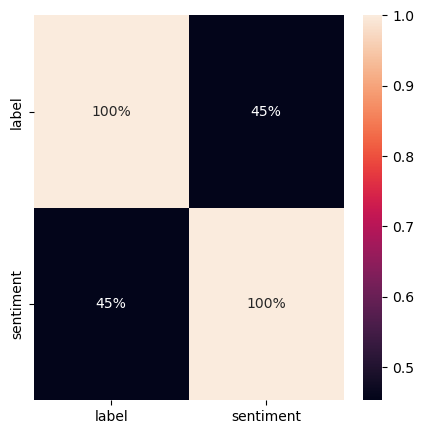

In [23]:

plt.figure(figsize=(5, 5))
sns.heatmap(NEW_df.corr(), fmt='.0%', annot=True)

In [24]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

(-0.5, 799.5, 399.5, -0.5)

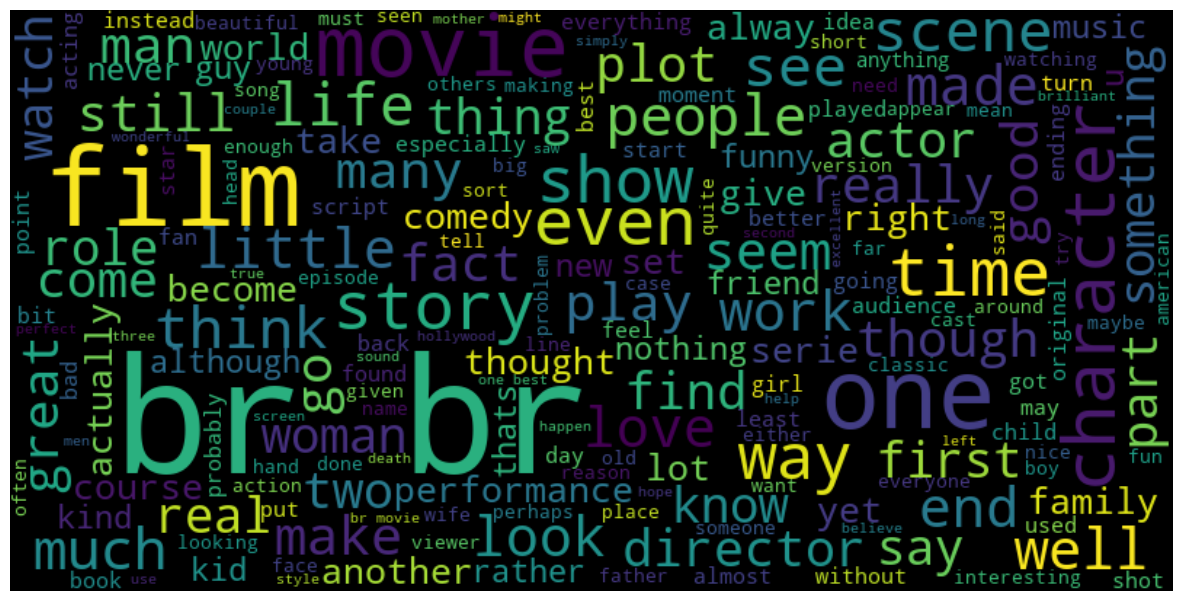

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming positive_reviews is a list of positive reviews as strings
positive_reviews = df[df['sentiment'] == 1]['text'].tolist()
positive_reviews_string = " ".join(positive_reviews)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(positive_reviews_string)

# Plot the WordCloud image
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

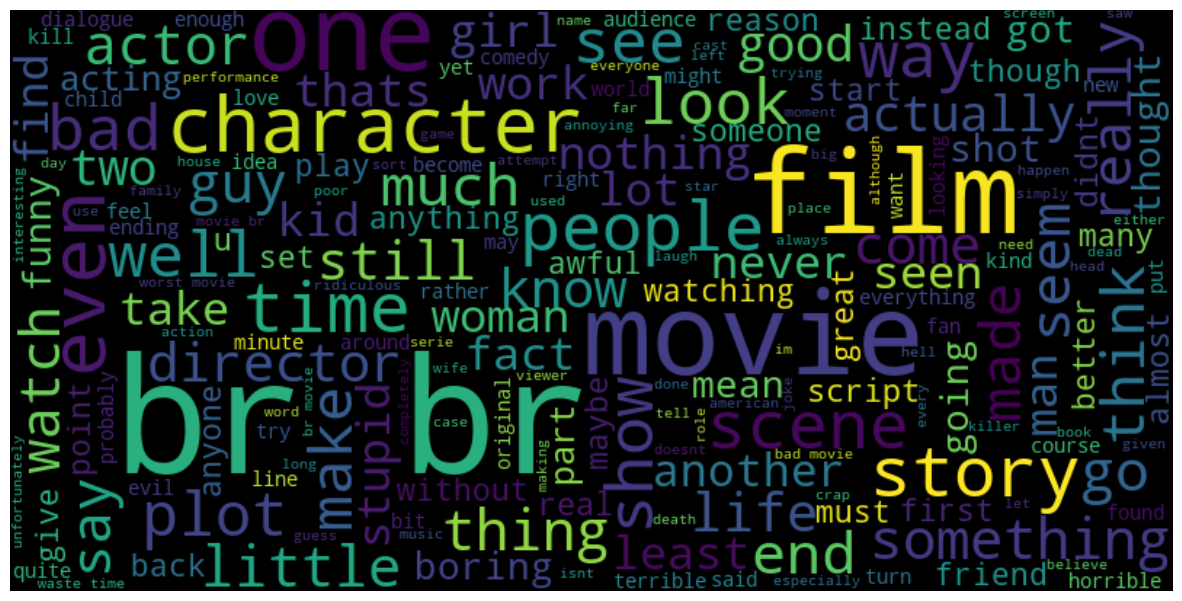

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming negative_reviews is a list of negative reviews as strings
negative_reviews = df[df['sentiment'] == 0]['text'].tolist()
negative_reviews_string = " ".join(negative_reviews)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(negative_reviews_string)

# Plot the WordCloud image
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<Axes: xlabel='sentiment', ylabel='count'>

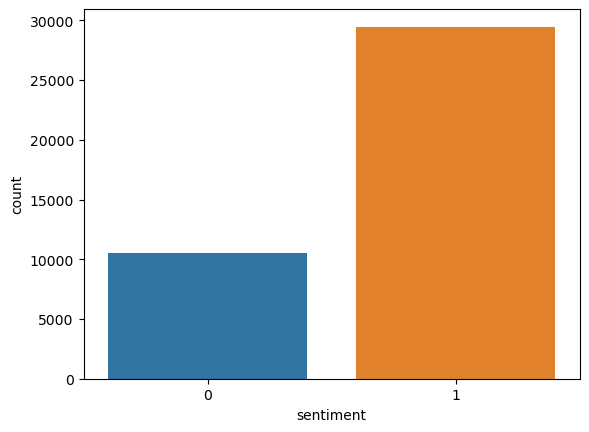

In [27]:
sns.countplot(data=df, x='sentiment' )

In [28]:
df.isna().sum().any()

False

In [29]:
df

,text,label,polarity_scores,sentiment
0,grew watching loving thunderbird mate school w...,0,0.163500,1
1,put movie dvd player sat coke chip expectation...,0,0.178916,1
2,people know particular time past like feel nee...,0,-0.167778,0
3,even though great interest biblical movie bore...,0,-0.241667,0
4,im die hard dad army fan nothing ever change g...,1,0.116860,1
...,...,...,...,...
39995,western union something forgotten classic west...,1,0.093317,1
39996,movie incredible piece work explores every noo...,1,0.230556,1
39997,wife watched movie plan visit sicily stromboli...,0,0.081988,1
39998,first watched flatliners amazed necessary feat...,1,0.327899,1


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from scipy import sparse  # Import the sparse module


# Assuming "text" is the column with text data
text_data = df["text"]

# Use TF-IDF to convert text data to numerical features
tfidf_vectorizer = TfidfVectorizer()
text_features = tfidf_vectorizer.fit_transform(text_data)

# Combine text features with numeric features
numeric_features = df.drop(["text"], axis=1)
combined_features = sparse.hstack([numeric_features, text_features])

# Resample using SMOTE
features_resampled, labels_resampled = SMOTE().fit_resample(combined_features, df["label"])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

In [37]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)

# use fit_transform on our standardized training features
x_train_pca = svd.fit_transform(x_train)

# use transform on our standardized test features
x_test_pca = svd.transform(x_test)

# look at the new shape of the transformed matrices
print('Training features matrix is: ', x_train_pca.shape)
print('Test features matrix is: ', x_test_pca.shape)


Training features matrix is:  (32030, 50)
Test features matrix is:  (8008, 50)


# model application 

In [38]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB()
naive.fit(x_train_pca, y_train)


GaussianNB()

In [39]:
# Make predictions on the test data
preds = naive.predict(x_test_pca)
print(accuracy_score(preds,y_test))

0.9679070929070929


# Classification Report

In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

In [41]:
acc = accuracy_score(y_test,preds)
print("Accuracy:", acc)
print("\n\n")
cm= confusion_matrix(y_test,preds)
print("confusion Matrix:", cm)
print("\n\n")
cr= classification_report(y_test,preds)
print("Classification Report:\n", cr)


Accuracy: 0.9679070929070929



confusion Matrix: [[4015    0]
 [ 257 3736]]



Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      4015
           1       1.00      0.94      0.97      3993

    accuracy                           0.97      8008
   macro avg       0.97      0.97      0.97      8008
weighted avg       0.97      0.97      0.97      8008



<function matplotlib.pyplot.show(close=None, block=None)>

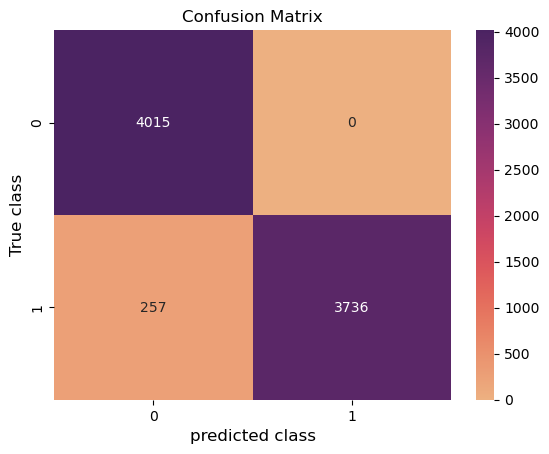

In [42]:
ax = sns.heatmap(cm, cmap='flare', annot= True, fmt= 'd')
plt.xlabel('predicted class',fontsize=12)
plt.ylabel('True class',fontsize=12)
plt.title('Confusion Matrix', fontsize=12)
plt.show